In [1]:
import os
from subprocess import PIPE, run
import time
import pandas as pd
import numpy as np 
import pprint
import requests


#### Data Bullshit

In [2]:
Data = pd.read_csv('/Users/sergiomares/Desktop/Nunez/Jin file/TSS_CpG_crispriphenotype_table.txt', delimiter = '\t',header = 0)
Data = Data.sort_values(["gene",'average phenotype of strongest 3'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')
UCSC_TSS = pd.read_csv('UCSC_TSS.txt', delimiter = '\t',header = 0)
UCSC_TSS = UCSC_TSS.drop_duplicates() 

errors = []

for gene in (Data['gene']):
        try:
                if len(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"]) > 1:
                        x = abs(UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"] - Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1]).min()
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = (int(Data[Data['gene'] == gene]["Primary TSS, 3'"].iloc[-1] - int(x) + 1))
                else:
                        x = UCSC_TSS[UCSC_TSS['hg19.kgXref.geneSymbol'] == gene]["hg19.knownGene.txStart"].iloc[-1]
                        Data.loc[Data['gene'] == gene, "Primary TSS, 3'"] = int(x) + 1 
              

        except:
            errors.append(gene)

len(errors)

Data = Data.reset_index()

In [3]:
Promoter_sequences = pd.read_csv('3kb_Promoter.sequences-2.csv', sep=',', header = 0)
Promoter_sequences = pd.merge(how = 'outer', left = Promoter_sequences, right = Data, left_on = 'Gene', right_on = 'gene')
Promoter_sequences = Promoter_sequences.dropna()

In [11]:
cpgs = pd.read_csv('1-s2-S0092867421003536-mmc3.csv',sep = ',',  header = 0)
cpgs = pd.DataFrame(cpgs)

# Only select a single value per gene, to prevent duplicates

cpgs = cpgs[['gene','CRISPRoff_average', 'mutant_average']]
cpgs = cpgs.sort_values(["gene",'CRISPRoff_average'], ascending = True).drop_duplicates(subset = 'gene', keep = 'first')

In [12]:
df = pd.merge(how = 'outer', left = Promoter_sequences, right = cpgs, left_on = 'Gene', right_on = 'gene')
df = df.loc[df.Gene.notna()]
df = df.reset_index()

In [108]:
df = df.dropna()

In [13]:
irbs = pd.read_csv('wgEncodeHaibMethylRrbsK562HaibSitesRep1.bed', sep='\t', header = 0)
#Extract only the values with 100% Certainty of methylation 
irbs = irbs[irbs['Unnamed: 8'] == '255,0,0']

chromosome_list = np.unique(irbs.track)

### 2 Kmers

In [7]:
tmp = np.zeros((len(df),3001))

for index, chromosomes in enumerate(chromosome_list):
    
    table = irbs[irbs['track'] == chromosomes]
    table2 = df[df.chromosome == chromosomes]

    for i, x in enumerate(table['name="SL725.1']):


        for o, z in enumerate(table2["Primary TSS, 3'"]):

            if (x > (z - 1500) and (x < (z + 1500))) == True:
                y = x - (z - 1500)
                #print((z - 1500), z,  (z + 1500))
                #print('CpG Islands found in:', x, 'Position on vector:', y,"in row", Promoter_sequences['gene'][o], o + 1)    

                tmp[df.level_0[df["Primary TSS, 3'"] == z ].iloc[-1] + 1][int(y)] = 1

In [15]:
kmer_length = 2

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [17]:
from collections import Counter

def Count_kmer(a_table, gc_elements, kmer):

    sequence = getKmers(str(a_table), kmer)

    gc_kmers = []
    gc_counts = Counter(sequence)

    for index, element in enumerate(gc_elements):

        if element in (dict(gc_counts)):
            gc_kmers.append((dict(gc_counts)[gc_elements[index]]))
        
        else:
            gc_kmers.append(0)
            #print(element, 'not in kmers')
            
    return(sum(gc_kmers)/3000*100)

#Promoter_sequences['kmers'] = Promoter_sequences.Sequences.apply(lambda x: Count_kmer(x, ['gg','cc','gc','cg'], 2))

Sequences_GC_kmers = [Count_kmer(i, ['gc'], 2) for i in df.Sequences]

In [32]:
kmers_2 = np.unique(getKmers(df.Sequences[1], 2))

In [45]:
Count_kmer(df.Sequences[1], ['aa'], 2)

8.733333333333333

In [109]:
DNA_features = pd.DataFrame(index = range(len(df.Sequences)), columns = kmers_2)

In [110]:

for i, o in enumerate(df.Sequences[:]):
    for x in kmers_2:
        DNA_features[x][i] = Count_kmer(o, [x], 2)


In [111]:
DNA_features

,aa,ac,ag,at,ca,cc,cg,ct,ga,gc,gg,gt,ta,tc,tg,tt
0,7.4,5.4,9.033333,3.633333,8.033333,9.466667,3.733333,6.566667,7.266667,7.766667,9.933333,4.1,2.766667,5.133333,6.366667,3.4
1,8.733333,5.366667,5.433333,8.7,8.166667,5.366667,0.533333,8.166667,4.5,3.933333,3.566667,4.8,6.833333,7.566667,7.266667,11.066667
2,9.333333,5.2,6.566667,7.866667,7.4,5.266667,0.766667,7.866667,6.0,3.766667,4.3,5.0,6.266667,7.066667,7.4,9.933333
3,8.6,5.466667,7.0,5.166667,6.266667,7.0,1.4,8.7,6.0,4.6,6.433333,5.466667,5.366667,6.3,7.666667,8.566667
4,4.466667,6.2,6.366667,3.8,8.266667,14.5,5.2,7.466667,4.233333,8.1,6.433333,4.4,3.9,6.6,5.166667,4.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18745,6.5,3.933333,6.333333,4.5,5.333333,7.366667,5.833333,6.433333,5.4,7.833333,8.966667,6.233333,4.0,5.833333,7.333333,8.166667
18746,7.4,3.2,8.4,4.966667,4.966667,7.133333,3.3,7.166667,7.4,5.966667,7.766667,5.266667,4.2,6.266667,6.933333,9.666667
18747,3.566667,3.6,7.366667,2.266667,4.766667,13.1,6.766667,7.233333,6.766667,8.633333,14.066667,4.466667,1.733333,6.533333,5.7,3.433333
18748,7.4,6.8,6.933333,5.3,8.5,6.7,2.166667,8.6,5.566667,5.466667,5.2,4.666667,4.933333,7.0,6.6,8.166667


In [112]:
DNA_array = np.array(DNA_features.astype('int'))
DNA_array = np.array(DNA_features)

feature_list = list(DNA_features.columns)

In [113]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(DNA_array, df.CRISPRoff_average, test_size = 0.25, random_state = 42)

In [114]:
# The baseline predictions are the historical averages
baseline_preds = test_features[:, feature_list.index('at')]
# Baseline errors, and display average baseline error
baseline_errors = abs(baseline_preds - test_labels)
print('Average baseline error: ', round(np.mean(baseline_errors), 2))

Average baseline error:  5.56


In [115]:
# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor( random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

In [116]:
# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

Mean Absolute Error: 0.07 degrees.


In [119]:
# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')


Accuracy: -29.69 %.


In [120]:
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Import tools needed for visualization
from sklearn.tree import export_graphviz
import pydot
# Pull out one tree from the forest
tree = rf.estimators_[5]
# Export the image to a dot file
export_graphviz(tree, out_file = 'tree.dot', feature_names = feature_list, rounded = True, precision = 1)
# Use dot file to create a graph
(graph, ) = pydot.graph_from_dot_file('tree.dot')
# Write graph to a png file
graph.write_png('tree.png')

In [121]:
# Limit depth of tree to 3 levels
rf_small = RandomForestRegressor(n_estimators=10, max_depth = 3)
rf_small.fit(train_features, train_labels)
# Extract the small tree
tree_small = rf_small.estimators_[5]
# Save the tree as a png image
export_graphviz(tree_small, out_file = 'small_tree.dot', feature_names = feature_list, rounded = True, precision = 1)
(graph, ) = pydot.graph_from_dot_file('small_tree.dot')
graph.write_png('small_tree.png');

In [123]:
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: aa                   Importance: 0.07
Variable: ac                   Importance: 0.07
Variable: cg                   Importance: 0.07
Variable: ag                   Importance: 0.06
Variable: ca                   Importance: 0.06
Variable: cc                   Importance: 0.06
Variable: ct                   Importance: 0.06
Variable: ga                   Importance: 0.06
Variable: gc                   Importance: 0.06
Variable: gg                   Importance: 0.06
Variable: gt                   Importance: 0.06
Variable: ta                   Importance: 0.06
Variable: tc                   Importance: 0.06
Variable: tg                   Importance: 0.06
Variable: tt                   Importance: 0.06
Variable: at                   Importance: 0.05


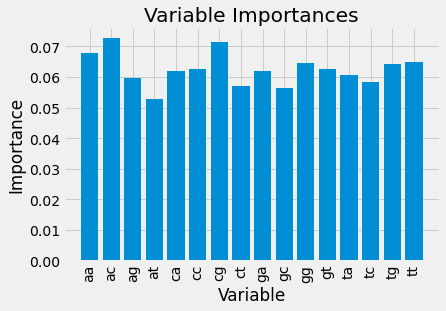

In [124]:
# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

### KMERS 3

In [128]:
kmer_length = 3

def getKmers(sequence, size):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [129]:
kmers_3 = np.unique(getKmers(df.Sequences[1], 3))

In [130]:
DNA_features = pd.DataFrame(index = range(len(df.Sequences)), columns = kmers_3)

In [132]:
for i, o in enumerate(df.Sequences[:]):
    for x in kmers_3:
        DNA_features[x][i] = Count_kmer(o, [x], 3)


In [ ]:
DNA_array = np.array(DNA_features.astype('int'))
DNA_array = np.array(DNA_features)

feature_list = list(DNA_features.columns)

In [ ]:
# Using Skicit-learn to split data into training and testing sets
from sklearn.model_selection import train_test_split
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(DNA_array, df.CRISPRoff_average, test_size = 0.25, random_state = 42)

# Import the model we are using
from sklearn.ensemble import RandomForestRegressor

# Instantiate model with 1000 decision trees
rf = RandomForestRegressor( random_state = 42)

# Train the model on training data
rf.fit(train_features, train_labels)

# Use the forest's predict method on the test data
predictions = rf.predict(test_features)
# Calculate the absolute errors
errors = abs(predictions - test_labels)
# Print out the mean absolute error (mae)
print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')

# Calculate mean absolute percentage error (MAPE)
mape = 100 * (errors / test_labels)
# Calculate and display accuracy
accuracy = 100 - np.mean(mape)
print('Accuracy:', round(accuracy, 2), '%.')

# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];


# Import matplotlib for plotting and use magic command for Jupyter Notebooks
import matplotlib.pyplot as plt
%matplotlib inline
# Set the style
plt.style.use('fivethirtyeight')
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical')
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');